In [2]:
import numpy as np

from matplotlib import pyplot as plt

from iminuit import Minuit

from scipy import stats

In [196]:
def pdf_class_A(x) :
    pdf_mode1 = stats.multivariate_normal.pdf(x, mean=(2,0), cov=[[2,0],[0,2]])
    pdf_mode2 = stats.multivariate_normal.pdf(x, mean=(0,2), cov=[[2,0],[0,2]])
    return pdf_mode1 + pdf_mode2

def logpdf_class_A(x) :
    return np.log(pdf_class_A(x))

def sample_class_A(n=1) :
    num_mode1      = int(np.sum(np.random.choice([0,1], size=(n,))))
    sample_mode1_x = 2. + np.sqrt(2.)*np.random.normal(size=(num_mode1,))
    sample_mode1_y = 0. + np.sqrt(2.)*np.random.normal(size=(num_mode1,))
    sample_mode1   = np.array([sample_mode1_x, sample_mode1_y]).transpose()
    sample_mode2_x = 0. + np.sqrt(2.)*np.random.normal(size=(n-num_mode1,))
    sample_mode2_y = 2. + np.sqrt(2.)*np.random.normal(size=(n-num_mode1,))
    sample_mode2   = np.array([sample_mode2_x, sample_mode2_y]).transpose()
    return np.concatenate([sample_mode1, sample_mode2])

def pdf_class_B(x) :
    pdf_mode1 = stats.multivariate_normal.pdf(x, mean=(0 ,-1), cov=[[4,0],[0,2]])
    pdf_mode2 = stats.multivariate_normal.pdf(x, mean=(-2,-3), cov=[[4,0],[0,4]])
    return pdf_mode1 + pdf_mode2

def sample_class_B(n=1) :
    num_mode1      = int(np.sum(np.random.choice([0,1], size=(n,))))
    sample_mode1_x = 0  + np.sqrt(4.)*np.random.normal(size=(num_mode1,))
    sample_mode1_y = -1 + np.sqrt(2.)*np.random.normal(size=(num_mode1,))
    sample_mode1   = np.array([sample_mode1_x, sample_mode1_y]).transpose()
    sample_mode2_x = -2 + np.sqrt(4.)*np.random.normal(size=(n-num_mode1,))
    sample_mode2_y = -3 + np.sqrt(4.)*np.random.normal(size=(n-num_mode1,))
    sample_mode2   = np.array([sample_mode2_x, sample_mode2_y]).transpose()
    return np.concatenate([sample_mode1, sample_mode2])

def logpdf_class_B(x) :
    return np.log(pdf_class_B(x))


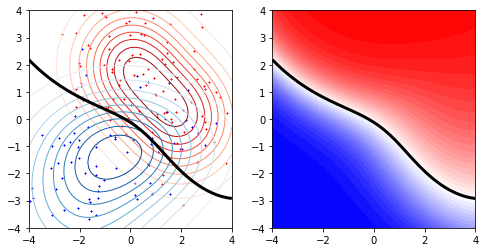

In [197]:
X = np.linspace(-4, 4, 41)
Y = np.linspace(-4, 4, 41)
X, Y = np.meshgrid(X, Y)
Z1 = np.zeros_like(X)
Z2 = np.zeros_like(X)
true_b = np.zeros_like(X)

for i in range(Z1.shape[0]) :
    for j in range(Z2.shape[1]) :
        pA, pB = pdf_class_A([X[i,j], Y[i,j]]), pdf_class_B([X[i,j], Y[i,j]])
        Z1[i,j], Z2[i,j] = pA, pB
        true_b[i,j] = pA / (pA + pB)
        
sA = sample_class_A(100)
sB = sample_class_B(100)
        
Z1 /= np.max(Z1)
Z2 /= np.max(Z2)

fig = plt.figure(figsize=(8, 4))
ax  = fig.add_subplot(121)
        
ax.contour(X, Y, Z1    , levels=np.linspace(0, 1, 11), linewidths=1, cmap="Reds" )
ax.contour(X, Y, Z2    , levels=np.linspace(0, 1, 11), linewidths=1, cmap="Blues")
ax.contour(X, Y, true_b, levels=[0.5], colors=["k"], linewidths=3)
ax.scatter(sA[:,0], sA[:,1], marker="x", c="r", s=1)
ax.scatter(sB[:,0], sB[:,1], marker="x", c="b", s=1)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

ax  = fig.add_subplot(122)
ax.contourf(X, Y, true_b, levels=np.linspace(0,1,41), cmap="bwr")
ax.contour (X, Y, true_b, levels=[0.5], colors=["k"], linewidths=3)
plt.show()


In [229]:
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

def classify_linear(x, params) :
    p = params[0]*x[:,0] + params[1]*x[:,1] + np.full(shape=(len(x),), fill_value=params[2])
    return sigmoid(p)

def classify_quadratic(x, params) :
    p = params[0]*x[:,0] + params[1]*x[:,0]*x[:,0] + params[2]*x[:,1] + np.full(shape=(len(x),), fill_value=params[3])
    return sigmoid(p)

def classifier_loss(x, y, classifier_params, weights=None, version="linear") :
    if version == "quad" : classifier_probs = classify_quadratic(x, classifier_params)
    else                 : classifier_probs = classify_linear   (x, classifier_params)
    classifier_bce   = y*np.log(classifier_probs) + (1-y)*np.log(1.-classifier_probs)
    if type(weights) == type(None) : weights = np.ones_like(y)
    return - np.mean(weights*classifier_bce) / np.sum(weights)
    
def get_new_classifier(n=0, xA=None, xB=None, reweight=False, version="linear") :
    if n > 0 :
        xA = sample_class_A(n)
        xB = sample_class_B(n)
    yA = np.ones (shape=(len(xA),))
    yB = np.zeros(shape=(len(xB),))
    wA, wB = np.ones_like(yA), np.ones_like(yB)
    if reweight :
        wA = np.random.poisson(lam=2, size=wA.shape)
        wB = np.random.poisson(lam=2, size=wB.shape)
    x = np.concatenate([xA, xB])
    y = np.concatenate([yA, yB])
    w = np.concatenate([wA, wB])
    loss = lambda params : classifier_loss(x, y, params, weights=w, version=version)
    if version == "quad" :
        m = Minuit.from_array_func(loss, 0.*np.random.normal(size=(4,)), error=[1,1,1,1], errordef=1)
    else :
        m = Minuit.from_array_func(loss, [1,1,0], error=[1,1,1], errordef=1)
    m.migrad()
    return xA, xB, wA, wB, m.np_values()


[ 0.91344596  0.8324675  -0.36742307]


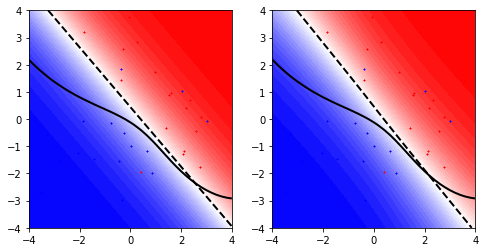

In [238]:
version = "linear"

fig = plt.figure(figsize=(8, 4))

X = np.linspace(-4, 4, 41)
Y = np.linspace(-4, 4, 41)
X, Y = np.meshgrid(X, Y)

xA, xB, _, _, params = get_new_classifier(n=20, version=version)
print(params)
b = np.zeros_like(X)
for i in range(Z.shape[0]) :
    for j in range(Z.shape[1]) :
            b[i,j] = classify(np.array([[X[i,j], Y[i,j]]]), params)

ax  = fig.add_subplot(1, 2, 1)
ax.contourf(X, Y, b, levels=np.linspace(0,1,41), cmap="bwr")
ax.contour(X, Y, b     , levels=[0.5], colors=["k"], linewidths=2, linestyles=["--"])
ax.contour(X, Y, true_b, levels=[0.5], colors=["k"], linewidths=2)
ax.scatter(xA[:,0], xA[:,1], marker="x", c="r", s=1)
ax.scatter(xB[:,0], xB[:,1], marker="x", c="b", s=1)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

classifiers = []
for classifier_idx in range(100) :
    _, _, wA, wB, params = get_new_classifier(xA=xA, xB=xB, reweight=True, version=version)
    classifiers.append(params)
    
b = np.zeros_like(X)
for i in range(Z.shape[0]) :
    for j in range(Z.shape[1]) :
        b[i,j] = np.mean([classify(np.array([[X[i,j], Y[i,j]]]), params) for params in classifiers])

ax  = fig.add_subplot(1, 2, 2)
ax.contourf(X, Y, b, levels=np.linspace(0,1,41), cmap="bwr")
ax.contour(X, Y, b     , levels=[0.5], colors=["k"], linewidths=2, linestyles=["--"])
ax.contour(X, Y, true_b, levels=[0.5], colors=["k"], linewidths=2)
ax.scatter(xA[:,0], xA[:,1], marker="x", c="r", s=1)
ax.scatter(xB[:,0], xB[:,1], marker="x", c="b", s=1)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

plt.show()